In [3]:
MY_API_TOKEN = 'e815c6fcf6d24a9da234bcd02d7e64bc'

In [68]:
# import http.client
# import json
# connection = http.client.HTTPConnection('api.football-data.org')
# headers = { 'X-Auth-Token': MY_API_TOKEN, 'X-Response-Control': 'minified' }
# connection.request('GET', '/v1/soccerseasons/440/teams', None, headers )
# response = json.loads(connection.getresponse().read().decode())
# pprint(response)
# teams = response['teams']
# print(len(teams))
# team_list = list()
# for team in teams:
#     name = team['shortName']
#     if name:
#         tid = team['id']
#         value = int(team['squadMarketValue'].replace(',','').replace(' €','')) if team['squadMarketValue'] is not None else 0
#         team_list.append({'tid':tid, 'name': name, 'value': value})
# data = pd.DataFrame(team_list)
# data.head()

In [40]:
import pandas as pd
import requests

In [98]:
def call_football_api(uri, result_key):
    result = requests.get(uri, headers = { 'X-Auth-Token': MY_API_TOKEN, 'X-Response-Control': 'full' })
    if result.status_code == 200:
        return result.json()[result_key]
    else:
        print('API is not reachable')
        return None

In [99]:
teams = call_football_api('http://api.football-data.org/v1/soccerseasons/440/teams', 'teams')
# pprint(teams)

In [184]:
teams_data = list()
for team in teams:
    name = team['name']
    tid = team['_links']['self']['href'].split('/')[-1]
    value = int(team['squadMarketValue'].replace(',','').replace(' €','')) if team['squadMarketValue'] is not None else 0
    wins = 0
    losses = 0
    goals = 0
    fixtures = call_football_api(team['_links']['fixtures']['href'], 'fixtures')
    for f in fixtures:
        # pprint(f)
        balls_home = f['result']['goalsHomeTeam'] if f['result']['goalsHomeTeam'] else 0
        balls_away = f['result']['goalsAwayTeam'] if f['result']['goalsAwayTeam'] else 0
        
        if balls_home or balls_away:  # there are non zerovalid values
            if name == f['homeTeamName']:
                goals += balls_home
                if balls_home > balls_away:
                    wins += 1
                elif balls_home < balls_away:
                    losses +=1
            else:
                goals += balls_away
                if balls_home < balls_away:
                    wins += 1
                elif balls_home > balls_away:
                    losses +=1
    teams_data.append({'tid':tid, 'name': name, 'value': value, 'wins': wins, 'losses': losses, 'goals': goals})

In [200]:
print(len(teams_data))
data = pd.DataFrame(teams_data)
data = data[['name', 'value', 'wins', 'goals', 'losses']].sort_values(by='value', axis=0, ascending=False).reset_index(drop=True)
data.head(32)

32


,name,value,wins,goals,losses
0,Real Madrid CF,764800000,30,110,2
1,FC Barcelona,756500000,28,117,7
2,FC Bayern München,566150000,31,110,6
3,Manchester City FC,525250000,28,102,8
4,Club Atlético de Madrid,501500000,26,72,6
5,Arsenal FC,492500000,25,97,10
6,Paris Saint-Germain,465400000,28,87,5
7,Juventus Turin,450800000,33,81,4
8,Tottenham Hotspur FC,429000000,27,89,6
9,Borussia Dortmund,376350000,22,98,9


In [201]:
import matplotlib.pyplot as plt
%matplotlib inline

In [164]:
# fig, ax = plt.subplots(figsize=(15, 12))
# ax.axis('off')

# ax.scatter(data['value'], data['wins'], c='black', s=70)

# for i in range(len(data)):
#     ax.annotate(data['name'][i], (data['value'][i], data['wins'][i]))
    

In [202]:
from scipy.cluster.vq import whiten, kmeans2

In [203]:
whitened = whiten(data[['value', 'wins']].as_matrix())

In [205]:
centroids, cluster_map = kmeans2(whitened, 4)
centroids, cluster_map

(array([[ 2.51389003,  2.38583188],
        [ 0.85709796,  1.4538663 ],
        [ 1.16167595,  2.09692255],
        [ 0.17326725,  0.0838769 ]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 3, 3, 1,
        3, 3, 3, 3, 3, 3, 3, 3, 3]))

In [206]:
colors_map = {0: 'r', 1: 'g', 2: 'b', 3: 'y', 4: 'm'}
colors = [colors_map[c] for c in cluster_map]

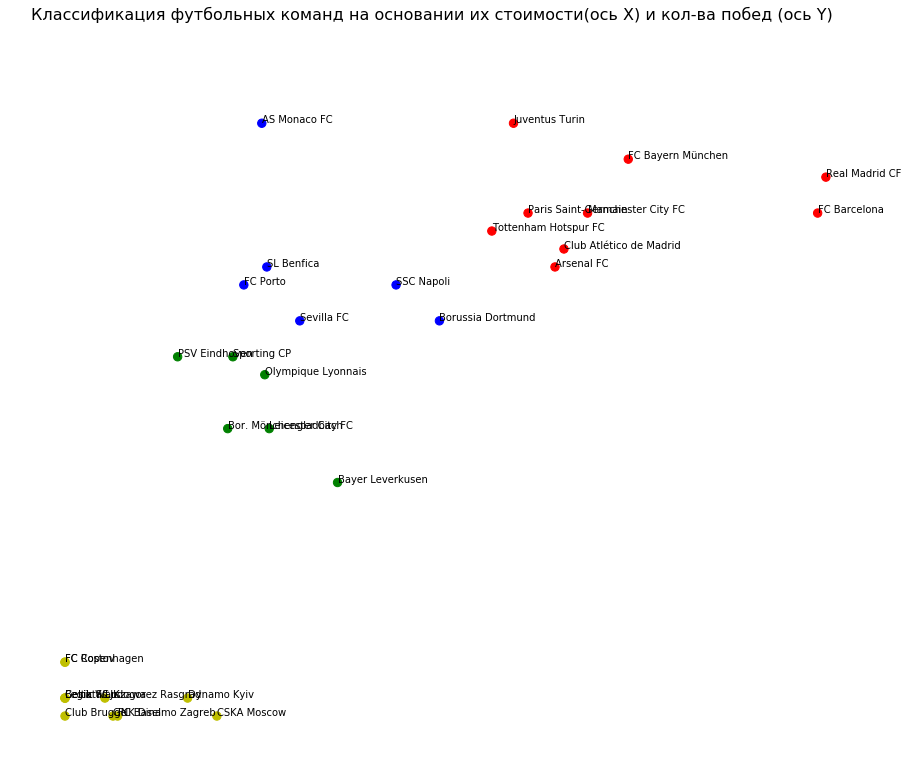

In [207]:
fig, ax = plt.subplots(figsize=(15, 12))
ax.axis('off')
fig.suptitle("Классификация футбольных команд на основании их стоимости(ось Х) и кол-ва побед (ось Y)", fontsize=16)
ax.scatter(data['value'], data['wins'], c=colors, s=70)
for i in range(len(data)):
    ax.annotate(data['name'][i], (data['value'][i], data['wins'][i]))